In [1]:
import tensorflow as tf
import os
import lxml.etree
import tqdm.notebook
import cv2
import numpy as np
import shutil
from google.colab import drive
drive.mount('/gdrive')
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from xml.etree import ElementTree
import tempfile
import time
from tqdm.notebook import tqdm
import random

Mounted at /gdrive


In [2]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    ''' Convolution block for darknet architecture '''
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

In [3]:
def DarknetResidual(x, filters):
    '''residual block for darknet architecture '''
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

In [4]:
def DarknetBlock(x, filters, blocks):
    ''' Darknet Block consisting of convolution and residual layers'''
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [5]:
def Darknet(name=None):
    ''' Darknet architecture '''
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [6]:
def YoloConv(filters, name=None):
    ''' convolution block for yolo architecture to detect objects '''
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [7]:
def YoloOutput(filters, anchors, classes, name=None):
    ''' Function to output predictions of object '''
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


In [8]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


In [ ]:
def pred(usequant, usegpu):
  # t1 - 3 outputs and save time
  # do the reamingsing ops
  # save the time t2

  return t1, t2, nms output

take 20 images
 - t1, t2,..gpu or cpu

avgt1, avgt2

In [9]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,masks=yolo_anchor_masks, classes=80, training=False):
    ''' YoloV3 architecture '''
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

In [10]:
def yolo_boxes(pred, anchors, classes):
    ''' Function to get absolute coordinates of bounding boxes and objectness and class probs'''
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    #print(class_probs)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  

    
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


In [12]:
def yolo_nms(outputs, anchors, masks, classes):
    ''' Function to prune number of bounding boxes to one with max iou score  '''
    
    b, c, t = [], [], []
    
    for o in outputs:
        
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=0.4,
        score_threshold=0.4
    )
    

    return boxes, scores, classes, valid_detections



In [12]:
def freeze_all(model,frozen=True):
  ''' Function to freeze layers in model '''
  model.trainable = not frozen
  if isinstance(model,tf.keras.Model):
    for l in model.layers:
      
      freeze_all(l,frozen)

In [13]:
def transform_images(x_train,size):
  ''' rescaling image to given size and normalizing image '''
  x_train = tf.image.resize(x_train,(size,size))
  x_train = x_train / 255
  return x_train

In [14]:
def transform_targets(y_train, anchors, anchor_masks, size):
    ''' Function to compute anchors idx where maximum overlap of bounding box and anchor boxes will be there '''
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)

In [15]:
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    ''' transforming targets for outputs by updating the particular grid cells for ground truth  '''
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x1, y1, x2, y2, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    
    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

In [16]:
def broadcast_iou(box_1, box_2):
    ''' computing iou for groundtruth and prediction  '''
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

In [17]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    ''' Loss function for YOLOV3 '''
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3)) 
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3)) 
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3)) 
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3)) 
        
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [18]:
def draw_output(image,outputs,class_names):
  ''' Function to draw bounding boxes in output '''
  boxes, objectness, classes, nums = outputs
  boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
  #boxes,objectness,classes,nums = outputs[0][0],outputs[1][0],outputs[2][0],outputs[3][0] 
  
  #print(np.flip(image.shape[0:2]))
  wh = np.flip(image.shape[0:2])
  #rint(classes)
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2])*wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4])*wh).astype(np.int32))
    image = cv2.rectangle(image,x1y1,x2y2,(255,0,0),2)
    
    if class_names[int(classes[i])] == 'D00':
      color = (0,255,0)
    elif class_names[int(classes[i])] == 'D10':
      color = (255,0,0)
    elif class_names[int(classes[i])] == 'D20':
      color = (255,255,0)
    else:
      color = (0,255,255)
    image = cv2.putText(image,'{} {:.4f}'.format(class_names[int(classes[i])], objectness[i]),x1y1, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
  return image

In [19]:
def draw_images(image_path,xml_path):
  ''' drawing bounding boxes in a image from xml files for visualizing ground truth '''
  damage_types = ['D00','D10','D20','D40'] #considering only 4 categories of damage types for this problem
  image = cv2.imread(image_path)
  #path = image_path.split('/')[-1].split('.')[0] # getting .xml file name from path
  
  xmlfile = open(xml_path)
  tree = ElementTree.parse(xmlfile)
  root = tree.getroot()
  
  for obj in root.iter('object'):
    class_name = obj.find('name').text
    if class_name not in damage_types:
      continue
    box = obj.find('bndbox')
    xmin = int(box.find('xmin').text)
    xmax = int(box.find('xmax').text)
    ymin = int(box.find('ymin').text)
    ymax = int(box.find('ymax').text)
    if class_name == 'D00':
      color = (0,255,0)
    elif class_name == 'D10': 
      color = (255,0,0)
    elif class_name == 'D20':
      color =  (255,255,0)
    else:
      color = (0,255,255)
      
      
    cv2.putText(image,class_name,(xmin,ymin),cv2.FONT_HERSHEY_SIMPLEX,1,color,2)
    cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(255,0,0),3)
  return image

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [20]:
num_classes = 4
classes = '/gdrive/MyDrive/Casestudy2/train/road_damage.classes'
weights = '/gdrive/MyDrive/Casestudy2/train/Combined_Dataset/checkpoints/yolov3_train_10.tf'
#image = '/gdrive/MyDrive/Casestudy2/train/Japan/images/Japan_002796.jpg'



yolo = YoloV3(size=416,channels = 3,classes=num_classes,training=True)


yolo.load_weights(weights).expect_partial()


class_names = [c.strip() for c in open(classes).readlines()]


<h2> Post-training float16 quantization </h2>

In [21]:

converter = tf.lite.TFLiteConverter.from_keras_model(yolo) # Converts a TensorFlow model into TensorFlow Lite model.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.allow_custom_ops = True
converter.experimental_new_converter = True
#converter.experimental_new_quantizer = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS] # as tf non max suppression is not supported in tf.lite so using via Opsset
converter.allow_custom_ops = True # as custom model contains some unknown operations to tflite so setting allow_custom_ops attribute to TRUE in order to convert tflite
converter.target_spec.supported_types = [tf.float16]

tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpmsd97e2r/assets


In [22]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

In [23]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

<h2> Inferences on CPU </h2>

In [126]:

input_shape = input_details[0]['shape']
image = '/content/train/Japan/images/Japan_002796.jpg'
#xml_path = '/content/train/India/annotations/xmls/India_003565.xml'
#true_image = draw_images(image,xml_path)
img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, 416)

#interpreter.set_tensor(input_details[0]['index'], img)

In [208]:
def predict(model,img,use_quant=False,use_gpu=False):
  pred = lambda x:yolo_nms(x,yolo_anchors,yolo_anchor_masks,4)
  if not use_quant:
    if not use_gpu:
      with tf.device('/CPU:0'):
        start_time_t1 = time.time()
        output_0,output_1,output_2 = model(img)
        t1 = time.time() - start_time_t1
    else:
      with tf.device('/GPU:0'):
        start_time_t1 = time.time()
        output_0,output_1,output_2 = model(img)
        t1 = time.time() - start_time_t1

    box_0 = yolo_boxes(output_0,yolo_anchors[yolo_anchor_masks[0]],4)
    box_1 = yolo_boxes(output_1,yolo_anchors[yolo_anchor_masks[1]],4) 
    box_2 = yolo_boxes(output_2,yolo_anchors[yolo_anchor_masks[2]],4)
    boxes,classes,scores,num = pred((box_0[:3],box_1[:3],box_2[:3]))
    t2 = time.time() - start_time_t1
    

  else:
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], img)
    if not use_gpu:
      with tf.device('/CPU:0'):
        start_time_t1 = time.time()
        model.invoke()
        t1 = time.time() - start_time_t1
    else:
      with tf.device('/GPU:0'):
        start_time_t1 = time.time()
        model.invoke()
        t1 = time.time() - start_time_t1
    output_0 = model.get_tensor(output_details[0]['index'])
    output_1 = model.get_tensor(output_details[1]['index'])
    output_2 =model.get_tensor(output_details[2]['index'])
    box_0 = yolo_boxes(output_0,yolo_anchors[yolo_anchor_masks[0]],4)
    box_1 = yolo_boxes(output_1,yolo_anchors[yolo_anchor_masks[1]],4)
    box_2 = yolo_boxes(output_2,yolo_anchors[yolo_anchor_masks[2]],4)
    boxes,classes,scores,num = pred((box_0[:3],box_1[:3],box_2[:3]))
    t2 = time.time() - start_time_t1
    
    
  return t1,t2,(boxes,classes,scores,num)
  
    





In [149]:
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/Japan_003221.jpg', 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, 416)

In [27]:
files = os.listdir('/content/Combined_Data/images')

In [178]:
# getting inferences,forward prop time and total time for unquantized model
forward_prop_time_ = []
total_inference_time = []
inferences = []
image_file = {}
for filename in tqdm(files[:20]):
  img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+filename, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, 416)
  f,t,inference = predict(yolo,img,use_quant=False,use_gpu=False)
  forward_prop_time.append(f)
  total_inference_time.append(t)
  image_file[filename] = inference
  inferences.append(inference)
forward_mean_time_CPU_unquantized_model = np.mean(np.asarray(forward_prop_time),axis=0)
total_inference_mean_time_CPU_unquantized_model = np.mean(np.asarray(total_inference_time),axis=0)
inferences_unquantized_model = image_file

In [174]:
# getting inferences,forward prop time and total time for quantized model

forward_prop_time_ = []
total_inference_time = []
inferences = []
image_file = {}
for filename in tqdm(files[:20]):
  img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+filename, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, 416)
  f,t,inference = predict(interpreter,img,use_quant=True,use_gpu=False)
  forward_prop_time.append(f)
  total_inference_time.append(t)
  image_file[filename] = inference
  inferences.append(inference)
forward_mean_time_CPU_quantized_model = np.mean(np.asarray(forward_prop_time),axis=0)
total_inference_mean_time_CPU_quantized_model = np.mean(np.asarray(total_inference_time),axis=0)
inferences_quantized_model = image_file

In [66]:
images = list(inferences_quantized_model.keys())

<h2> Visualising predictions of quantized and unquantized models </h2>

In [91]:
index = random.randint(0,19)
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_unquantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
unquantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

In [92]:
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_quantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
quantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

Text(0.5, 1.0, 'Unquantized model prediction')

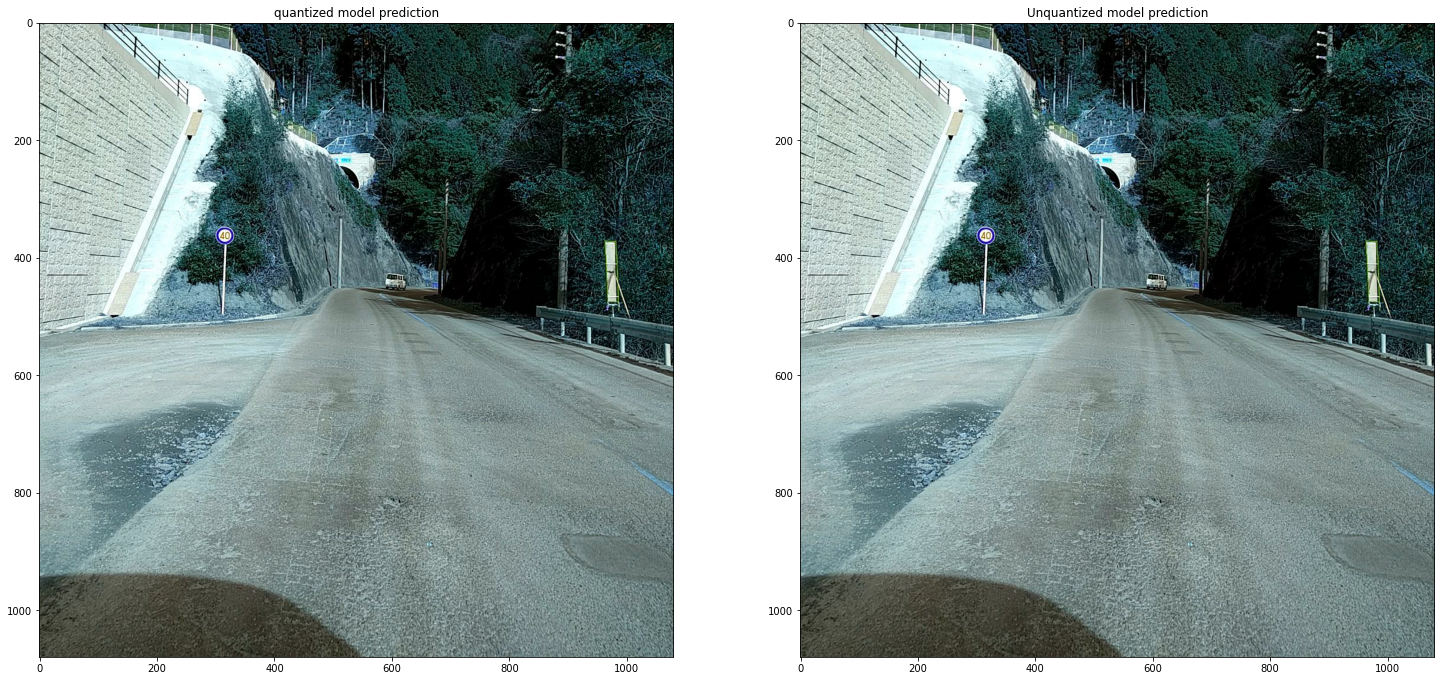

In [93]:
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(img)
ax[0].set_title('quantized model prediction')
ax[1].imshow(unquantized_img)
ax[1].set_title('Unquantized model prediction')
#from IPython.display import Image, display
#display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [152]:
index = random.randint(0,19)
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_unquantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
unquantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

In [153]:
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_quantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
quantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

Text(0.5, 1.0, 'Unquantized model prediction')

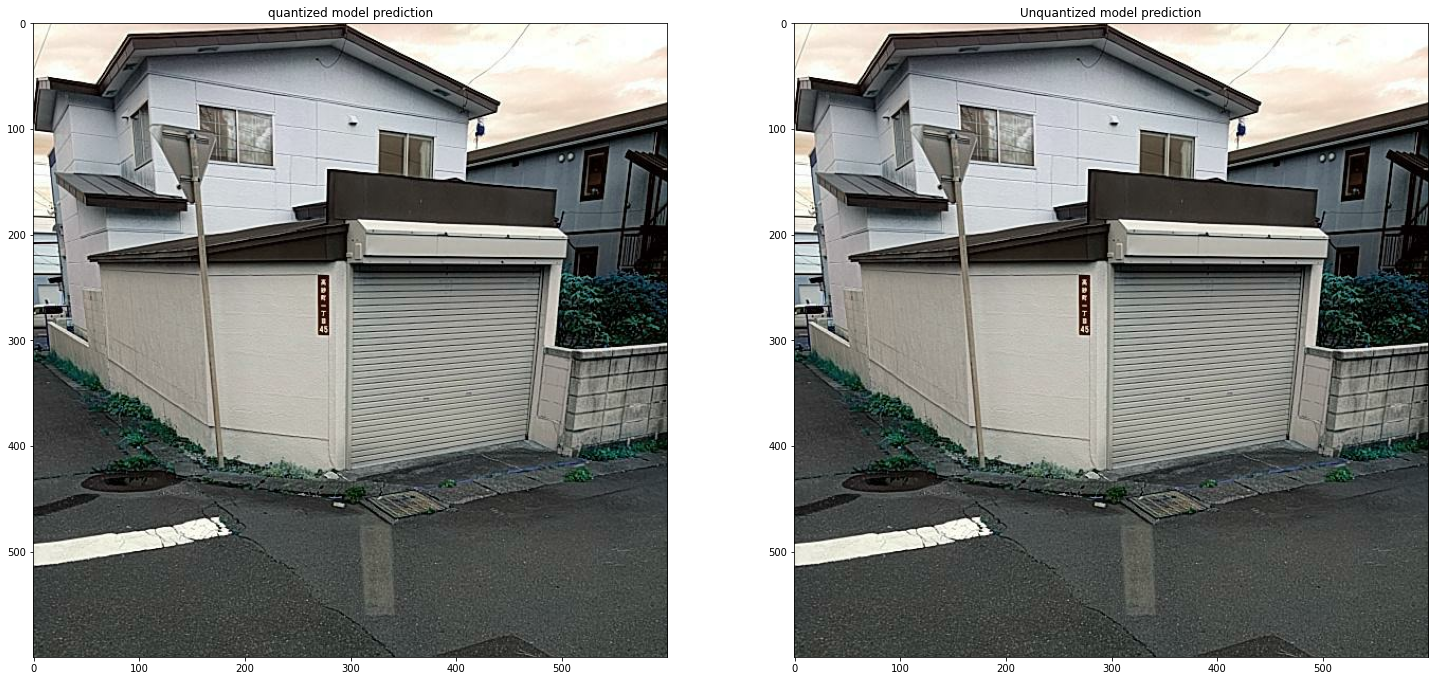

In [154]:
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(img)
ax[0].set_title('quantized model prediction')
ax[1].imshow(unquantized_img)
ax[1].set_title('Unquantized model prediction')
#from IPython.display import Image, display
#display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

<h2> Inferences on GPU </h2>

In [210]:
# getting inferences,forward prop time and total time for unquantized model
forward_prop_time = []
total_inference_time = []
inferences = []
image_file = {}
for filename in tqdm(files[:20]):
  img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+filename, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, 416)
  f,t,inference = predict(yolo,img,use_quant=False,use_gpu=True)
  forward_prop_time.append(f)
  total_inference_time.append(t)
  image_file[filename] = inference
  inferences.append(inference)
forward_mean_time_GPU_unquantized_model = np.mean(np.asarray(forward_prop_time),axis=0)
total_inference_mean_time_GPU_unquantized_model = np.mean(np.asarray(total_inference_time),axis=0)
inferences_unquantized_model = image_file

In [167]:
# getting inferences,forward prop time and total time for quantized model

forward_prop_time_ = []
total_inference_time = []
inferences = []
image_file = {}
for filename in tqdm(files[:20]):
  img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+filename, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, 416)
  f,t,inference = predict(interpreter,img,use_quant=True,use_gpu=True)
  forward_prop_time.append(f)
  total_inference_time.append(t)
  image_file[filename] = inference
  inferences.append(inference)
forward_mean_time_GPU_quantized_model = np.mean(np.asarray(forward_prop_time),axis=0)
total_inference_mean_time_GPU_quantized_model = np.mean(np.asarray(total_inference_time),axis=0)
inferences_quantized_model = image_file

In [168]:
images = list(inferences_quantized_model.keys())

<h2> Visualising predictions of quantized and unquantized models </h2>

In [169]:
index = random.randint(0,19)
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_unquantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
unquantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

In [170]:
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_quantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
quantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

Text(0.5, 1.0, 'Unquantized model prediction')

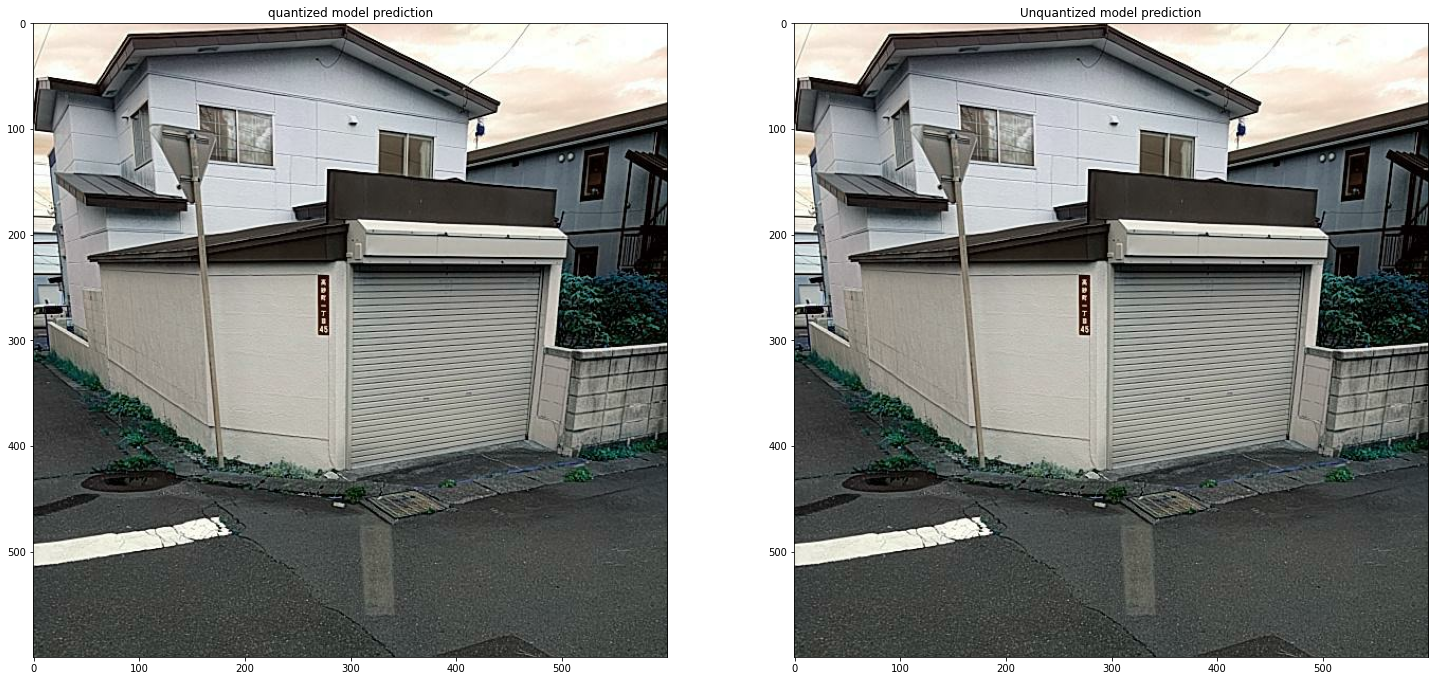

In [162]:
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(img)
ax[0].set_title('quantized model prediction')
ax[1].imshow(unquantized_img)
ax[1].set_title('Unquantized model prediction')
#from IPython.display import Image, display
#display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [163]:
index = random.randint(0,19)
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_unquantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
unquantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

In [164]:
img_raw = tf.image.decode_image(open('/content/Combined_Data/images/'+images[index], 'rb').read(), channels=3)
boxes,scores,classes,nums = inferences_quantized_model[images[index]]
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
quantized_img = draw_output(img, (boxes, scores, classes, nums), class_names)

Text(0.5, 1.0, 'Unquantized model prediction')

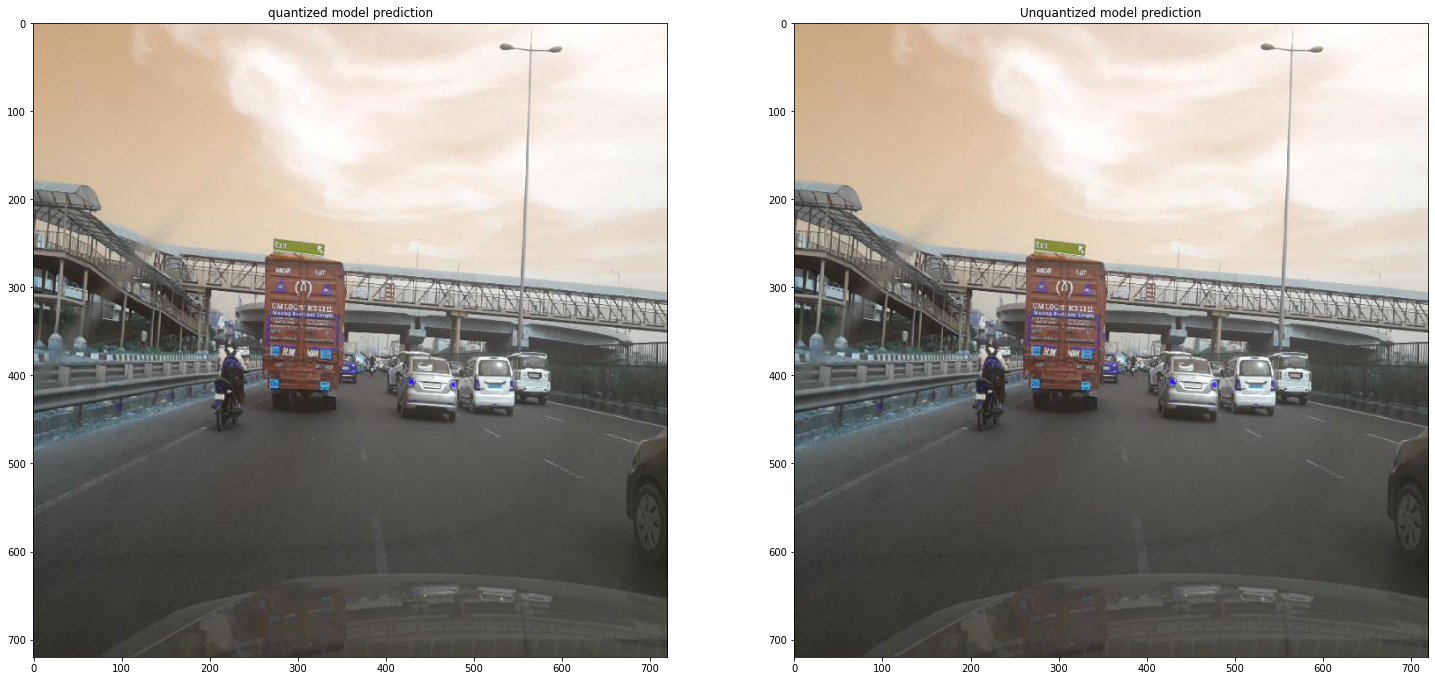

In [165]:
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(img)
ax[0].set_title('quantized model prediction')
ax[1].imshow(unquantized_img)
ax[1].set_title('Unquantized model prediction')
#from IPython.display import Image, display
#display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

<h2> Comparisons of sizes of quantized models and unquantized models </h2>

In [ ]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(yolo)
float_converter.allow_custom_ops = True
float_tflite_model = float_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpe13tm0a1/assets


INFO:tensorflow:Assets written to: /tmp/tmpe13tm0a1/assets


In [ ]:
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(tflite_quant_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

#computing  file size in MB because because os.path.getsize gives size in bytes and  2 ^ 20 is 1 MB
print("Float model in Mb:", os.path.getsize(float_file) / float(2**20)) 
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

Float model in Mb: 234.7437515258789
Quantized model in Mb: 117.44760131835938


In [ ]:
modelsize_without_quantization = os.path.getsize(float_file)
modelsize_with_quantization = os.path.getsize(quant_file)


In [ ]:
table = PrettyTable()
table.field_names = ['Model_Type','Model_Size']
table.add_row(['Model_without_quantization',modelsize_without_quantization / float(2**20)])
table.add_row(['Qunatized_Model',modelsize_with_quantization / float(2**20)])
print(table)

+----------------------------+--------------------+
|         Model_Type         |     Model_Size     |
+----------------------------+--------------------+
| Model_without_quantization | 234.7437515258789  |
|      Qunatized_Model       | 117.44760131835938 |
+----------------------------+--------------------+


<h2> Observations </h2>
<ol>
<li> When we used float16 quantization on model then size of the model drastically reduced by 2x from 234 MB to 117 MB </li>
<li> So when productionize the model if there is limitations of memory then model can be quantized in order to reduce the size as per the requirements of Computer architecture </li>

<h2> Prediction Rates on CPU </h2>

In [ ]:
prediction_rate_unquantized_model = '2.03 seconds' # computed average of 4 predictions
prediction_rate_quantized_model = '1.79 seconds' # computed average of 4 predictions

In [182]:
prediction_rate_table = PrettyTable()
prediction_rate_table.title = 'Prediction Rate on CPU'
prediction_rate_table.field_names = ['Model Type','Forward Prop Rate','Total Time rate(with NMS)']
prediction_rate_table.add_row(['Model_without_quantization',forward_mean_time_CPU_unquantized_model,total_inference_mean_time_CPU_unquantized_model])
prediction_rate_table.add_row(['Quantized_Model',forward_mean_time_CPU_quantized_model,total_inference_mean_time_CPU_quantized_model])
print(prediction_rate_table)

+-----------------------------------------------------------------------------+
|                            Prediction Rate on CPU                           |
+----------------------------+--------------------+---------------------------+
|         Model Type         | Forward Prop Rate  | Total Time rate(with NMS) |
+----------------------------+--------------------+---------------------------+
| Model_without_quantization | 0.9546617371471304 |     1.3048630475997924    |
|      Quantized_Model       | 0.9309757150394816 |     1.0749986290931701    |
+----------------------------+--------------------+---------------------------+


<h2> Note </h2>
<p>Time Rate is in seconds </p>

<h2> Observations </h2>
<ol>
<li> From above table comparison, we can conclude and observe that our experiments on CPU with quantized model gave slightly faster results then Model without quantization </li>
<li> So this model can be inference faster on CPU than GPU and hence if machine has only CPU architecture then Quantized model can be useful for inferences or predictions </li>

<h2> Prediction Rates on GPU </h2>

In [211]:
prediction_rate_table = PrettyTable()
prediction_rate_table.title = 'Prediction Rate on GPU'
prediction_rate_table.field_names = ['Model Type','Forward Prop Rate','Total Time rate(with NMS)']
prediction_rate_table.add_row(['Model_without_quantization',forward_mean_time_GPU_unquantized_model,total_inference_mean_time_GPU_unquantized_model])
prediction_rate_table.add_row(['Quantized_Model',forward_mean_time_GPU_quantized_model,total_inference_mean_time_GPU_quantized_model])
print(prediction_rate_table)

+-----------------------------------------------------------------------------+
|                            Prediction Rate on GPU                           |
+----------------------------+--------------------+---------------------------+
|         Model Type         | Forward Prop Rate  | Total Time rate(with NMS) |
+----------------------------+--------------------+---------------------------+
| Model_without_quantization | 0.0643232822418213 |    0.07697192430496216    |
|      Quantized_Model       | 0.8926123624942341 |     1.0564318776130677    |
+----------------------------+--------------------+---------------------------+


<h2> Observations </h2>
<ol>
<li>  From above table comparison, we can conclude and observe that our experiments on GPU with unquantized model gave faster results then quantized Model </li>
<li> So if computer architecture has GPU then unquantized model can inference faster than Quantized model </li>